# Medical Image - TFM
<h4>subtitle: Generación de una tubería distribuida para la extracción de características en imágenes médicas patológicas</h4>
license: European Union Public Licence (EUPL) v1.2

<table>
  <tr> <td> author name: </td> <td> Israel Llorens </td> </tr>
  <tr> <td> email: </td> <td> sanchezis@hotmail.com </td> </tr>
</table>

<h7>date: 2024/03/22</h7>

---

In [1]:
%load_ext autoreload
%autoreload

## Loading Libraries

In [1]:
try:
    from stardist.models import StarDist2D
except:
    pass
import skimage

import matplotlib.pyplot as plt

from IPython.display import display_html

import os
import sys
import init

In [7]:
import glob
import random

images_path = os.path.join(
                os.path.dirname(
                    os.getcwd()
                ),
                'data',
                'patient_extracts/'
                )


images_list = list(os.walk(
                    images_path
                )
            )[0][2]

image_file_name = os.path.join(images_path, images_list[random.randint(0, len(images_list))])

## Find the downloaded data images from previous stages and Select randomly 1

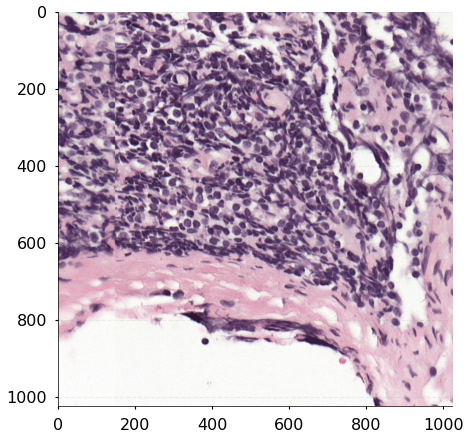

In [77]:
import random

random.randint(0, len(images_list))

image_file_name = os.path.join(images_path, images_list[random.randint(0, len(images_list))])

image = skimage.io.imread(image_file_name)

plt.imshow(image)

## Use the selected image to test the StarDist Library

In [78]:
# creates a pretrained model
model_he = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


|2025-03-23|15:59:38.715| [WARNING] functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 1024, 1024, 3))

|2025-03-23|15:59:39.202| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21212121844291687..1.0].


Text(0.5, 1.0, 'Found nucleotid Labels')

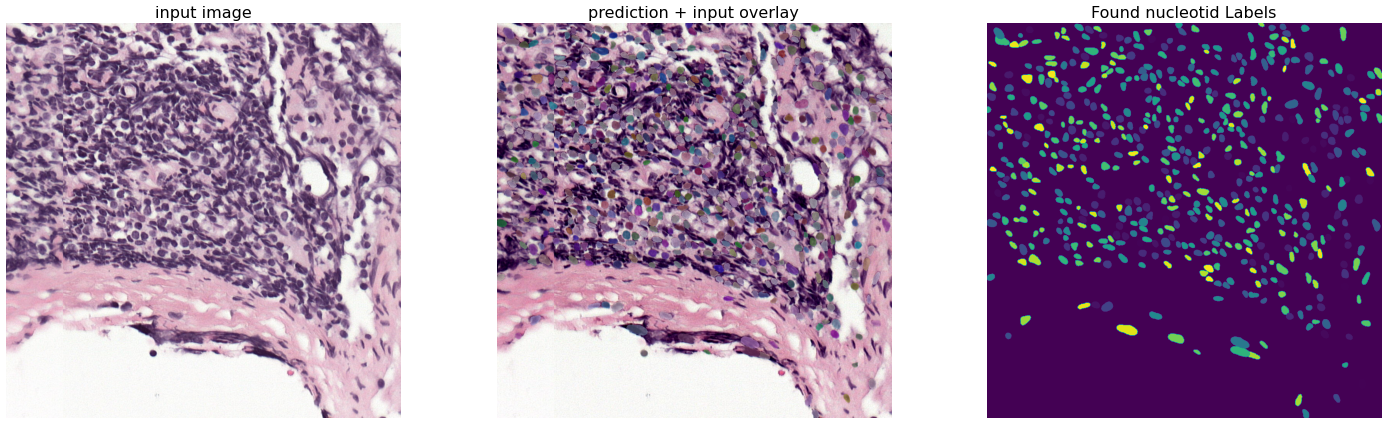

In [79]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

# img = test_image_nuclei_2d()

labels, _ = model_he.predict_instances(normalize(image))

plt.subplot(1,3,1)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,3,2)
plt.imshow(render_label(labels, img=image))
plt.axis("off")
plt.title("prediction + input overlay")

plt.subplot(1,3,3)
plt.imshow(labels)
plt.axis("off")
plt.title("Found nucleotid Labels")


## Choose another library or framework to extract another characteristic from the image

In [99]:
"""Import modules required to run the Jupyter notebook."""

from __future__ import annotations

# Clear logger to use tiatoolbox.logger
import logging

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

import copy
import os
import random
import shutil
import warnings
from collections import OrderedDict
from pathlib import Path
from typing import TYPE_CHECKING, Callable

# Third party imports
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F  # noqa: N812

# Use ujson as replacement for default json because it's faster for large JSON
import ujson as json
from shapely.geometry import box as shapely_box
from shapely.strtree import STRtree
from skimage.exposure import equalize_hist
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as PlattScaling
from sklearn.metrics import average_precision_score as auprc_scorer
from sklearn.metrics import roc_auc_score as auroc_scorer
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.nn import BatchNorm1d, Linear, ReLU
from torch.utils.data import Sampler
from torch_geometric.data import Batch, Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    EdgeConv,
    GINConv,
    global_add_pool,
    global_max_pool,
    global_mean_pool,
)
from tqdm import tqdm

from tiatoolbox import logger
from tiatoolbox.data import stain_norm_target
from tiatoolbox.models import (
    DeepFeatureExtractor,
    IOSegmentorConfig,
    NucleusInstanceSegmentor,
)
from tiatoolbox.models.architecture.vanilla import CNNBackbone
from tiatoolbox.tools.graph import SlideGraphConstructor
from tiatoolbox.tools.patchextraction import PatchExtractor
from tiatoolbox.tools.stainnorm import get_normalizer

# ! save_yaml, save_as_json => need same name, need to factor out jsonify
from tiatoolbox.utils.misc import download_data, save_as_json, select_device
from tiatoolbox.utils.visualization import plot_graph
from tiatoolbox.wsicore.wsireader import (
    OpenSlideWSIReader,
    # Resolution,
    # Units,
    WSIReader,
)

if TYPE_CHECKING:  # pragma: no cover
    from collections.abc import Iterator

warnings.filterwarnings("ignore")
mpl.rcParams["figure.dpi"] = 150  # for high resolution figure in notebook

In [4]:
# Clear logger to use tiatoolbox.logger
import logging
import warnings

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm

from tiatoolbox import logger
from tiatoolbox.models.architecture.unet import UNetModel
from tiatoolbox.models.engine.semantic_segmentor import (
    IOSegmentorConfig,
    SemanticSegmentor,
)
from tiatoolbox.utils.misc import download_data, imread
from tiatoolbox.utils.visualization import overlay_prediction_mask
from tiatoolbox.wsicore.wsireader import WSIReader

|2025-03-23|22:05:41.476| [INFO] A new version of Albumentations is available: 2.0.5 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [5]:
model_file_name = "tissue_mask_model.pth"
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk//models/seg/fcn-tissue_mask.pth",
    model_file_name,
)

PosixPath('tissue_mask_model.pth')

In [9]:
# Tile prediction
bcc_segmentor = SemanticSegmentor(
    pretrained_model="fcn_resnet50_unet-bcss",
    num_loader_workers=4,
    batch_size=4,
)

import shutil

shutil.rmtree("sample_tile_results/", ignore_errors=True)

output = bcc_segmentor.predict(
    [image_file_name],
    save_dir="sample_tile_results/",
    mode="tile",
    resolution=1.0,
    units="baseline",
    patch_input_shape=[1024, 1024],
    patch_output_shape=[512, 512],
    stride_shape=[512, 512],
    # on_gpu=False,
    crash_on_exception=True,
)

|2025-03-23|22:07:39.233| [WARNING] /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tiatoolbox/models/architecture/__init__.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rel

|2025-03-23|22:07:48.938| [INFO] A new version of Albumentations is available: 2.0.5 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations
|2025-03-23|22:07:48.939| [INFO] A new version of Albumentations is available: 2.0.5 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations
|2025-03-23|22:07:48.946| [INFO] A new version of Albumentations is available: 2.0.5 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations
|2025-03-23|22:07:48.947| [INFO] A new version of Albumentations is available: 2.0.5 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


|2025-03-23|22:07:49.374| [WARNING] Raw data is None.
Process Batch: 100%|##############################| 1/1 [00:12<00:00, 12.36s/it]

|2025-03-23|22:07:53.393| [INFO] Finish: 0
|2025-03-23|22:07:53.394| [INFO] --Input: /Users/illorens/Projects/source/Universidad/viu-MU-BD-and-DS-Image-Pathology/data/patient_extracts/patient_004_node_2.tif_tile_368_x19456_y34816_score9905.0.png
|2025-03-23|22:07:53.394| [INFO] --Output: /Users/illorens/Projects/source/Universidad/viu-MU-BD-and-DS-Image-Pathology/notebooks/sample_tile_results/0


|2025-03-23|22:08:21.400| [INFO] Prediction method output is: /Users/illorens/Projects/source/Universidad/viu-MU-BD-and-DS-Image-Pathology/data/patient_extracts/patient_004_node_2.tif_tile_368_x19456_y34816_score9905.0.png, /Users/illorens/Projects/source/Universidad/viu-MU-BD-and-DS-Image-Pathology/notebooks/sample_tile_results/0
|2025-03-23|22:08:21.406| [INFO] Raw prediction dimensions: (1024, 1024, 5)
|2025-03-23|22:08:21.417| [INFO] Processed prediction dimensions: (1024, 1024)
|2025-03-23|22:08:21.448| [INFO] Input image dimensions: (1024, 1024, 3)


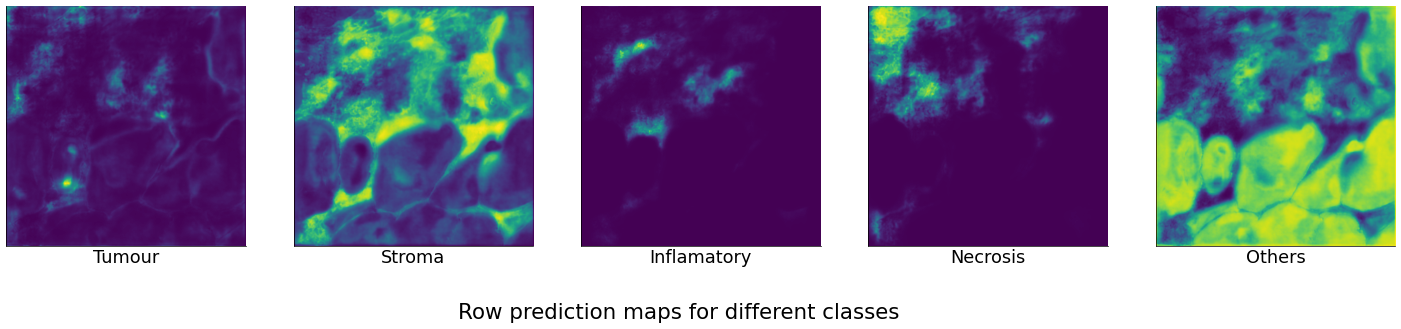

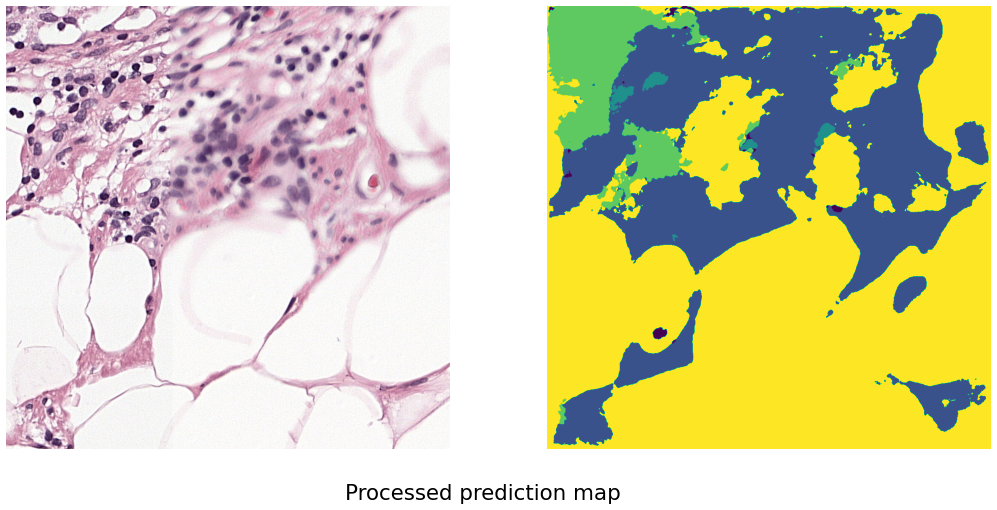

In [11]:
logger.info(
    "Prediction method output is: %s, %s",
    output[0][0],
    output[0][1],
)
tile_prediction_raw = np.load(
    output[0][1] + ".raw.0.npy",
)  # Loading the first prediction [0] based on the output address [1]
logger.info(
    "Raw prediction dimensions: (%d, %d, %d)",
    tile_prediction_raw.shape[0],
    tile_prediction_raw.shape[1],
    tile_prediction_raw.shape[2],
)

# Simple processing of the raw prediction to generate semantic segmentation task
tile_prediction = np.argmax(
    tile_prediction_raw,
    axis=-1,
)  # select the class with highest probability
logger.info(
    "Processed prediction dimensions: (%d, %d)",
    tile_prediction.shape[0],
    tile_prediction.shape[1],
)

# showing the predicted semantic segmentation
tile = imread(image_file_name)
logger.info(
    "Input image dimensions: (%d, %d, %d)",
    tile.shape[0],
    tile.shape[1],
    tile.shape[2],
)

fig = plt.figure()
label_names_dict = {
    0: "Tumour",
    1: "Stroma",
    2: "Inflamatory",
    3: "Necrosis",
    4: "Others",
}
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    (
        plt.imshow(tile_prediction_raw[:, :, i]),
        plt.xlabel(
            label_names_dict[i],
        ),
        ax.axes.xaxis.set_ticks([]),
        ax.axes.yaxis.set_ticks([]),
    )
fig.suptitle("Row prediction maps for different classes", y=0.15)

# showing processed results
fig2 = plt.figure(figsize=(20,9))
ax1 = plt.subplot(1, 2, 1), plt.imshow(tile), plt.axis("off")
ax2 = plt.subplot(1, 2, 2), plt.imshow(tile_prediction), plt.axis("off")
fig2.suptitle("Processed prediction map", y=0.05);

In [12]:
tile_prediction = np.argmax(tile_prediction_raw, axis=-1)
bins = np.bincount(tile_prediction.flatten())
list( zip (label_names_dict.values(),  np.round( bins / np.sum(bins) * 100, 4)  ) )

[('Tumour', 0.211),
 ('Stroma', 33.4949),
 ('Inflamatory', 0.5244),
 ('Necrosis', 6.7736),
 ('Others', 58.9962)]

## Second iteration

In [13]:
import numpy as np
import histomicstk as htk
import skimage
import scipy as sp
from urllib import request
import certifi
import ssl

context = ssl.create_default_context(cafile=certifi.where())
https_handler = request.HTTPSHandler(context=context)
opener = request.build_opener(https_handler)
request.install_opener(opener)

# Load reference image for normalization
ref_image_file = (  'https://data.kitware.com/api/v1/file/'
                    '57718cc28d777f1ecd8a883c/download')  # L1.png

im_reference = skimage.io.imread(ref_image_file)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

In [15]:
images_list[:20]

['patient_005_node_2.tif_tile_462_x17408_y122880_score9435.0.png',
 'patient_000_node_3.tif_tile_58_x40960_y49152_score23181.8.png',
 'patient_005_node_0.tif_tile_136_x0_y94208_score22950.0.png',
 'patient_004_node_2.tif_tile_96_x94208_y109568_score25500.0.png',
 'patient_004_node_2.tif_tile_19_x3072_y21504_score25500.0.png',
 'patient_008_node_0.tif_tile_49_x69632_y2048_score23181.8.png',
 'patient_008_node_0.tif_tile_341_x39936_y148480_score11169.4.png',
 'patient_005_node_0.tif_tile_208_x61440_y102400_score13770.0.png',
 'patient_005_node_2.tif_tile_594_x27648_y115712_score6120.0.png',
 'patient_009_node_2.tif_tile_57_x7168_y195584_score25500.0.png',
 'patient_010_node_3.tif_tile_230_x33792_y45056_score1896.7.png',
 'patient_000_node_3.tif_tile_517_x43008_y111616_score421.5.png',
 'patient_004_node_2.tif_tile_162_x92160_y113664_score24024.8.png',
 'patient_005_node_2.tif_tile_418_x79872_y104448_score10710.0.png',
 'patient_000_node_3.tif_tile_472_x51200_y126976_score1475.2.png',
 'p

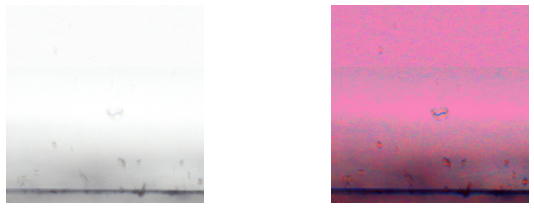

In [16]:

image = skimage.io.imread( os.path.join(images_path,  
                                        'patient_009_node_2.tif_tile_57_x7168_y195584_score25500.0.png',
                                        # 'patient_004_node_1.tif_tile_247_x33792_y77824_score13005.0.png'
                                        ) )
# image = skimage.io.imread('./out/patient_000_node_0/25_117.png')

im_input = image[:, :, :3]

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(im_input, mean_ref, std_ref)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].axis('off')
ax[0].imshow( image )
ax[1].axis('off')
ax[1].imshow( im_nmzd )

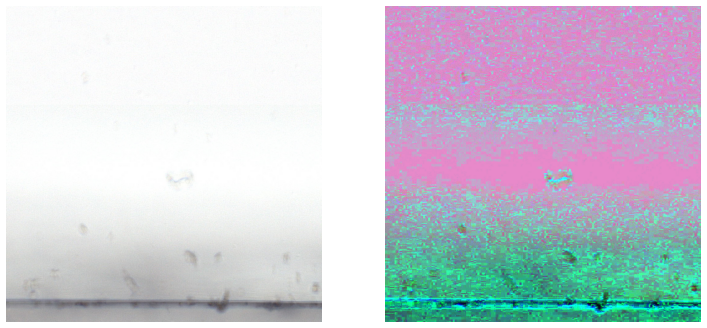

In [ ]:
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([  stainColorMap[stain_1],
                stainColorMap[stain_2],
                stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W).Stains

fig, ax = plt.subplots(1,2, figsize=(14,7))
ax[0].axis('off')
ax[0].imshow( image )
ax[1].axis('off')
ax[1].imshow( im_stains )

In [18]:
# Hyperparameters

# segment foreground
foreground_threshold = 60

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

# filter out small objects
min_nucleus_area = 80


# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(im_nuclei_stain < foreground_threshold)

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(im_log_max, im_fgnd_mask, local_max_search_radius)

im_nuclei_seg_mask = htk.segmentation.label.area_open(im_nuclei_seg_mask, min_nucleus_area).astype(int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print('Number of nuclei = ', len(objProps))

|2025-03-23|22:09:48.084| [WARNING] /var/folders/4l/tlk6snvn7h74kq99qnbyg3ch0000gn/T/ipykernel_66038/3681112102.py:20: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(im_nuclei_stain < foreground_threshold)



Number of nuclei =  71


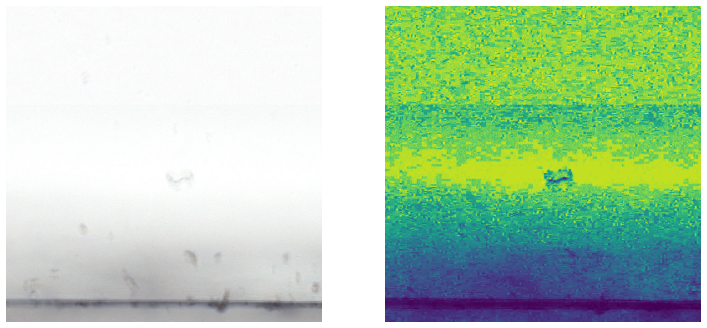

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
ax[0].axis('off')
ax[0].imshow( image )
ax[1].axis('off')
ax[1].imshow( im_nuclei_stain )

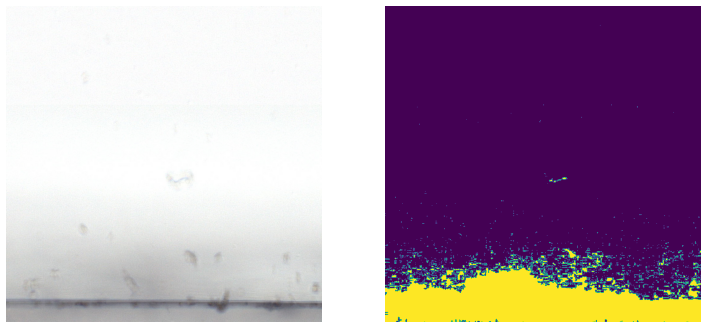

In [21]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
ax[0].axis('off')
ax[0].imshow( image )
ax[1].axis('off')
ax[1].imshow( im_fgnd_mask )

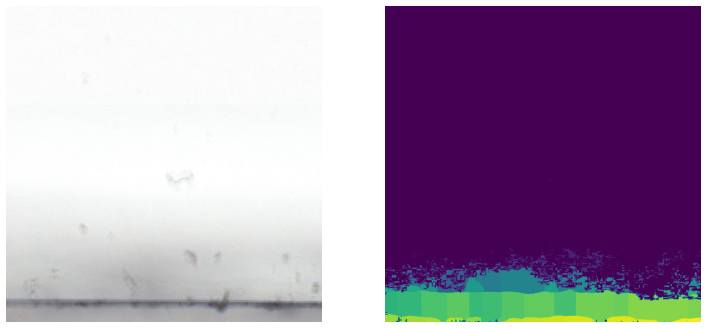

In [22]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
ax[0].axis('off')
ax[0].imshow( image )
ax[1].axis('off')
ax[1].imshow( im_nuclei_seg_mask )

In [23]:
[
dict(
  zip(
  ['area', 
  'area_bbox', 
  'area_convex', 
  'area_filled', 
  'bbox', 
  'centroid', 
  'euler_number', 
  'perimeter', 
  'slice']
  , 
  (
    obj.area, 
    obj.area_bbox, 
    obj.area_convex, 
    obj.area_filled, 
    obj.bbox, 
    obj.centroid, 
    obj.euler_number, 
    obj.perimeter, 
    obj.slice
  )
)
)
for obj in objProps ][:13]

[{'area': 98.0,
  'area_bbox': 297.0,
  'area_convex': 173.0,
  'area_filled': 98.0,
  'bbox': (555, 565, 566, 592),
  'centroid': (558.8061224489796, 579.0204081632653),
  'euler_number': 4,
  'perimeter': 50.76345596729059,
  'slice': (slice(555, 566, None), slice(565, 592, None))},
 {'area': 105.0,
  'area_bbox': 646.0,
  'area_convex': 388.0,
  'area_filled': 105.0,
  'bbox': (558, 527, 575, 565),
  'centroid': (565.8095238095239, 545.4190476190477),
  'euler_number': 7,
  'perimeter': 72.00609665440987,
  'slice': (slice(558, 575, None), slice(527, 565, None))},
 {'area': 121.0,
  'area_bbox': 1674.0,
  'area_convex': 826.0,
  'area_filled': 121.0,
  'bbox': (766, 327, 820, 358),
  'centroid': (796.0247933884298, 343.1570247933884),
  'euler_number': 13,
  'perimeter': 90.2842712474619,
  'slice': (slice(766, 820, None), slice(327, 358, None))},
 {'area': 180.0,
  'area_bbox': 3268.0,
  'area_convex': 2114.0,
  'area_filled': 180.0,
  'bbox': (789, 64, 832, 140),
  'centroid': (80

## Another output

In [24]:
import numpy as np
import scipy as sp

from skimage import io
import skimage.io
import skimage.measure
import skimage.color

import cv2 as cv
import os
import openslide
import xml.etree.cElementTree as ET
import random
import os 
import glob

import fsspec

import histomicstk as htk
import tifffile
from tiffslide import TiffSlide

import PIL
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [25]:
try:
    import pyspark
    from pyspark.sql.functions import col, isnan, when, count,to_date,year,month,expr,hour,dayofweek,lower,array_remove,collect_list,lit
    from pyspark.sql.functions import pandas_udf,split
    from pyspark.sql.types import ArrayType, DoubleType, StringType
    from pyspark.sql.types import StructField,StructType,StringType,DoubleType,FloatType,IntegerType
    import pyspark.sql.functions as F
except:
    pass

In [26]:
from digital_pathology.spark import spark

In [27]:
df = spark.read.format("binaryFile")\
    .option("pathGlobFilter", "*.png")\
    .load( os.path.join(images_path, "*.png") )\
    .withColumn('type',     F.slice( F.split('path', '/'), F.size( F.split('path', '/')) , 1) .getItem(0)      )\
    .withColumn('patient_key', F.regexp_extract(F.col('type'), pattern=r'(?i)(patient_[0-9]+_node_[0-9]+\.tif)', idx=1))\
    .withColumn('patient_id',  F.regexp_extract(F.col('patient_key'), pattern=r'(?i)(patient_[0-9]+)', idx=1))

In [28]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- type: string (nullable = true)
 |-- patient_key: string (nullable = true)
 |-- patient_id: string (nullable = true)



In [29]:
df.groupBy('patient_id').count().sort('patient_id')

+-----------+-----+
| patient_id|count|
+-----------+-----+
|patient_000|  854|
|patient_004| 1230|
|patient_005| 1382|
|patient_008|  762|
|patient_009|  324|
|patient_010|  924|
+-----------+-----+

In [30]:
# Pandas Styler with bigger font
styled_df = (
    df.select( F.round( F.sum('length')/1024**2, 2).cast('string').alias('Total (MB)') ).toPandas()
    .style
    .set_properties(**{'font-size': '24px', 'text-align': 'center'})
    .hide(axis="index")
)

display_html(
    styled_df.to_html(), 
    raw=True
    )

Total (MB) 
 
 
 
 
 7475.54

In [31]:
df_img = df.select(['path','content', 'type']).limit(1).first()[0]

In [32]:
df.select(['patient_key','path', 'type']).limit(2).toPandas()

patient_key                                                                                                                                                                   path                                                           type
0  patient_004_node_2.tif   file:/Users/illorens/Projects/source/Universidad/viu-MU-BD-and-DS-Image-Pathology/data/patient_extracts/patient_004_node_2.tif_tile_813_x30720_y93184_score210.7.png   patient_004_node_2.tif_tile_813_x30720_y93184_score210.7.png
1  patient_000_node_3.tif  file:/Users/illorens/Projects/source/Universidad/viu-MU-BD-and-DS-Image-Pathology/data/patient_extracts/patient_000_node_3.tif_tile_529_x27648_y109568_score210.7.png  patient_000_node_3.tif_tile_529_x27648_y109568_score210.7.png

In [33]:
from pyspark.sql.window import Window

df = df.withColumn('original_order', F.monotonically_increasing_id())
df = df.withColumn('row_num', F.row_number().over(Window.orderBy('original_order')))
df = df.drop('original_order')

In [34]:
display(df.select(['row_num', 'path', 'type']).filter(F.col('row_num')>1).limit(1))

+-------+--------------------+--------------------+
|row_num|                path|                type|
+-------+--------------------+--------------------+
|      2|file:/Users/illor...|patient_000_node_...|
+-------+--------------------+--------------------+

In [35]:
img = df.select(['path', 'type','row_num', ]).filter(F.col('row_num')>1).limit(1).first()[0]

## Run the Tiatoolbox process

In [36]:
BINARY_FILES_SCHEMA = StructType(
    [
        # StructField("tile_prediction",  BinaryType()),
        StructField("bins", StringType()),
        StructField("out", StringType()),
        # StructField("content", ArrayType(BinaryType())),
    ]
)


from tiatoolbox import logger
from tiatoolbox.models.architecture.unet import UNetModel
from tiatoolbox.models.engine.semantic_segmentor import (
    IOSegmentorConfig,
    SemanticSegmentor,
)
from tiatoolbox.utils.misc import download_data, imread
from tiatoolbox.utils.visualization import overlay_prediction_mask
from tiatoolbox.wsicore.wsireader import WSIReader

model_file_name = "tissue_mask_model.pth"
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk//models/seg/fcn-tissue_mask.pth",
    model_file_name,
)


@F.udf(returnType = BINARY_FILES_SCHEMA)
def extract_tumor(path, img_name, img_path, DEBUG=True):
    import logging
    import os
    import numpy as np
    from tiatoolbox.models.engine.semantic_segmentor import SemanticSegmentor


    # Disable logging to avoid issues
    import logging
    logger = logging.getLogger()
    logger.setLevel(logging.CRITICAL)
    
    label_names_dict = {
        0: "Tumour",
        1: "Stroma",
        2: "Inflamatory",
        3: "Necrosis",
        4: "Others",
        }

    # Tile prediction
    bcc_segmentor = SemanticSegmentor(
        pretrained_model=model_file_name, # "fcn_resnet50_unet-bcss", # Ensure this path is worker-accessible
        num_loader_workers=0,    # Avoid Multiprocessing in UDF CRUCIAL: Disable multiprocessing
        batch_size=4,
    )
    
    out_location = os.path.join(img_path, f"sample_tile_results/{img_name}")
    logging.warning(out_location)
    
    import shutil
    #os.rmdir(f"sample_tile_results/{img[2]}")
    try:
        shutil.rmtree(out_location, exist_ok=True)
    except:
        pass
    
    output = bcc_segmentor.predict(
        [path],
        save_dir=out_location,
        mode="tile",
        resolution=1.0,
        units="baseline",
        patch_input_shape=[1024, 1024],
        patch_output_shape=[512, 512],
        stride_shape=[512, 512],
        on_gpu=False,
        crash_on_exception=True,
    )
    
    tile_prediction_raw = np.load(
        output[0][1] + f"{img_name}.raw.0.npy",
    ) 
    
    tile_prediction = np.argmax(
        tile_prediction_raw,
        axis=-1,
    ) 
    bins = np.bincount(tile_prediction.flatten())
    out = str( list( zip (label_names_dict.values(),  np.round( bins / np.sum(bins) * 100, 4)  ) ) )
    tile = imread(path)

    return [ 
            # Image.fromarray(tile_prediction), 
            str(bins),
            out,
            # [tile,] 
            ] 

features = df.withColumn('image',   
                        extract_tumor( 
                                    F.regexp_replace( 'path', 'file:', ''), 
                                    'type' ,
                                    F.lit(images_path)
                                    ) 
                        ) 

spark.sparkContext.addFile(model_file_name)
spark.sparkContext.addFile(model_file_name[:-4]+'.lock')

In [37]:
import init
from digital_pathology.spark import spark

from pyspark.sql import functions as F

def check_import():
    import tiatoolbox  # Will fail on workers if environment isn't set
    return "Success"

spark.udf.register("test_udf", check_import)
spark.sql("SELECT test_udf()").show()

+----------+
|test_udf()|
+----------+
|   Success|
+----------+



features.drop('content')\
        .write.mode('overwrite')\
        .parquet('../data/2-process.parquet')